# 读取文件 

In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
sys.path.append(r'C:\Users\81004\1_jupyter_code\1_Functions')
import matplotlib.pyplot as plt
from cal_ppp_dis import cal_ppp_distance as cal_dis

In [68]:
# 读取xyz数据

file_path =  r'D:\MD_file\Corning\march\laso4\results\cry_1000p_out.xyz'

ana_frame = 0
###########

# 要分析的元素
ana_element = ['Al','Si','O']
# 画出分布的元素
draw_element = ['O']

In [70]:
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)

    return frames

# 使用之前的frames列表
frames = read_xyz_frames(file_path)


# 开始

ana_frame = 200
ana_element = ['Nb','O']

In [74]:
# 找出最大的x、y和z值
max_x = max([i['x'] for i in frames[ana_frame]['atoms']])
max_y = max([i['y'] for i in frames[ana_frame]['atoms']])
max_z = max([i['z'] for i in frames[ana_frame]['atoms']])

box_size_old = [max_x+0.01,max_y+0.01,max_z+0.01]
print(box_size_old)
print(frames[0]['atoms'][0])
data_list = []
for i in frames[ana_frame]['atoms']:
    data_list.append([i['element'],i['x'],i['y'],i['z']])

[119.27879700000001, 59.622997999999995, 11.34156]
{'element': 'O', 'x': 101.214797, 'y': 29.850598, 'z': 2.49539}


# 使用pyscal计算Q4-Q6

In [77]:
from pyscal3 import System
from pyscal3 import Atoms

In [79]:
sys = System()
sys.box = [[max_x+0.01,0,0],[0,max_y+0.01,0],[0,0,max_z+0.01]]
print(sys.box)

[[119.27879700000001, 0, 0], [0, 59.622997999999995, 0], [0, 0, 11.34156]]


# 筛选部分原子

In [82]:
data_list[0]

['O', 101.214797, 29.850598, 2.49539]

In [83]:
# 将list转为字典 取出我们要分析的元素 
ana_atom_list = []
atom_xyz = []
for i in data_list:
    if i[0] in ana_element: 
        atom_xyz.append(i[1:])
        ana_atom_list.append(i)
print(np.array(atom_xyz).shape)

(5226, 3)


In [86]:
# 转换元素格式
adict = {"positions": np.array(atom_xyz, dtype=object)}
atoms = Atoms(adict)
print(atoms.species)
print(atoms.positions)
# 实例化
sys.atoms = atoms

[None None None ... None None None]
[[101.214797 29.850598 2.49539]
 [83.982197 15.398498 9.86993]
 [112.054797 55.619798 10.73926]
 ...
 [107.627797 51.730298 5.6262]
 [115.177797 38.850398 1.06754]
 [10.344697 48.050098 3.37591]]


# 尝试一下其他近邻算法

Text(0.5, 1.0, 'Cutoff adaptive method')

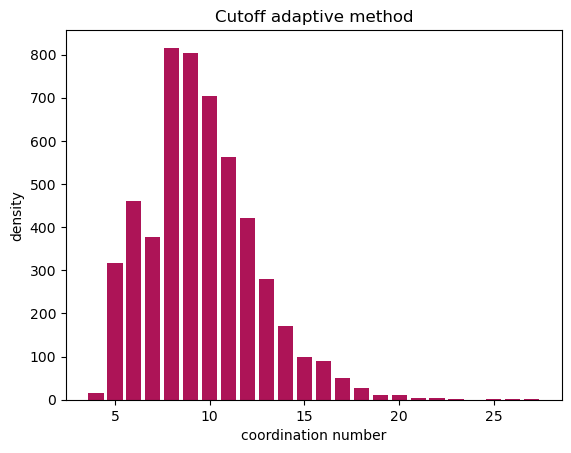

In [89]:
# 这是pyscal3的Adaptive cutoff methods
sys.find.neighbors(method='cutoff', cutoff='adaptive', padding=1.5)
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
#################
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Cutoff adaptive method")

#这是 Voronoi method计算得到的
sys.find.neighbors(method='voronoi')
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Voronoi method")

# cutoff 算法
sys.find.neighbors(method='cutoff', cutoff = set_cutoff)
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Cutoff method")

In [92]:
# 计算q4和q6 然后采用均值的方法
q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
# 分配值
q4 = q4_q6_list[0]
q6 = q4_q6_list[1]

In [93]:
sum(q4_q6_list[0])/len(q4_q6_list[0])

0.15177438395746548

In [94]:
draw_element = ['O']

In [95]:
results_xyz_q4_q6 = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element:
        results_xyz_q4_q6.append([i_atom[1],i_atom[2],i_atom[3],q4[i],q6[i]])
print(results_xyz_q4_q6[0])

[101.214797, 29.850598, 2.49539, 0.11986766074330077, 0.06262909117125205]


# 得到了所有结果，现在可以可视化分布了

In [97]:
# 把结果筛选一遍 
new_res = results_xyz_q4_q6.copy()
# 仅保留中间区域的晶体
# z_range = [40,50]
filtered_res = []
for i in new_res:
    # if i[2]<z_range[1] and i[2]>z_range[0]:
        filtered_res.append(i)

In [98]:
filtered_res[0]

[101.214797, 29.850598, 2.49539, 0.11986766074330077, 0.06262909117125205]

See Origin Figure
Mean q4:  0.1388    Percentage of Q4 > 0.18: 19.63%


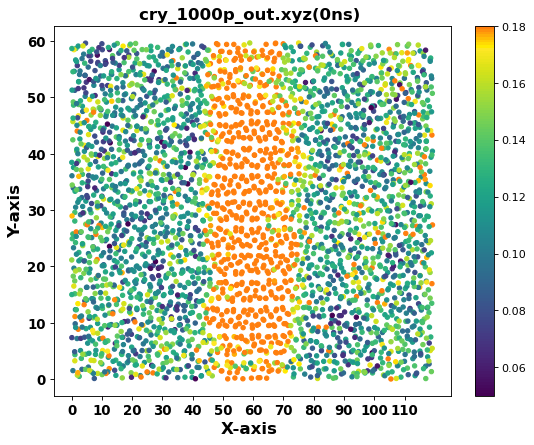

In [99]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
# 从 data_list 中提取 x、y、q4 和 q6 数据
data_temp = results_xyz_q4_q6
# data_temp = filtered_res

#########
x_data = [item[0] for item in data_temp]
y_data = [item[1] for item in data_temp]
q4_data = [item[3] for item in data_temp]
q6_data = [item[4] for item in data_temp]

# 创建二维分布图
plt.figure(figsize=(8, 6) ,dpi=80)

# 绘制 q4 在 x-y 平面上的二维分布图
print('See Origin Figure')

mean_q4 = sum(q4_data)/len(q4_data)
max_q4 = 0
for i in q4_data:
    if i>0.18:
        max_q4+=1
print('Mean q4:  ' + str(round(mean_q4,4))+'    Percentage of Q4 > 0.18: '+ str(round(max_q4/len(q4_data)*100,2))+'%')

###########################################
# 定义viridis色谱的底端绿色渐变

viridis_cmap = plt.get_cmap('viridis')

# 生成顶端橙黄色的渐变，使用非常短的橙色段
orange_yellow = ['#ffea00', '#ff7f0e']  # 橙色到黄色的 HEX 色码，顺序调整为黄色到橙色
orange_yellow_cmap = LinearSegmentedColormap.from_list('orange_yellow', orange_yellow, N=8)

# 合并两个色谱，创建自定义色谱
colors = np.vstack((viridis_cmap(np.linspace(0, 1, 128)),
                    orange_yellow_cmap(np.linspace(0, 1, 8))))  # 使用非常短的橙色段
custom_cmap = ListedColormap(colors)
###########################################################

name_x = file_path.split('\\')[-1]
# 绘制 q4 在 x-y 平面上的二维分布图
title_name = name_x+ '(' + str( ana_frame*10) + 'ns) '

plt.title(title_name , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗

################
plt.scatter(x_data, y_data, s=15, c=q4_data, cmap=custom_cmap, marker='o',vmin=0.05, vmax=0.18)
plt.colorbar()
# plt.title('O' , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗
plt.xlabel('X-axis ', fontsize=15, fontweight='bold')  # 设置 x 轴标签字体大小和加粗
plt.ylabel('Y-axis', fontsize=15, fontweight='bold')  # 设置 y 轴标签字体大小和加粗

# 设置 x 轴刻度值的字体大小、颜色和加粗
plt.xticks(range(0, int(max(x_data)) + 1, 10), fontsize=12, fontweight='bold')
# 设置 y 轴刻度值的字体大小、颜色和加粗
plt.yticks(fontsize=12, fontweight='bold')

# 参考线
# # 添加X参考线
# plt.axvline(x=20, color='black', linestyle='-')  
# plt.axvline(x=40, color='black', linestyle='-')  
# plt.axvline(x=60, color='black', linestyle='-') 
# plt.axvline(x=80, color='black', linestyle='-')
# # 添加Y参考线
# plt.axhline(y=20, color='black', linestyle='-') 
# plt.axhline(y=40, color='black', linestyle='-') 
# plt.axhline(y=60, color='black', linestyle='-') 
# plt.axhline(y=80, color='black', linestyle='-') 
# #plt.xticks(np.arange(0, 95, 20))
#plt.yticks(np.arange(0, 95, 20))

# 显示图形
plt.show()


Mean q4:  0.1388    Percentage of Q4 > 0.18: 32.78%


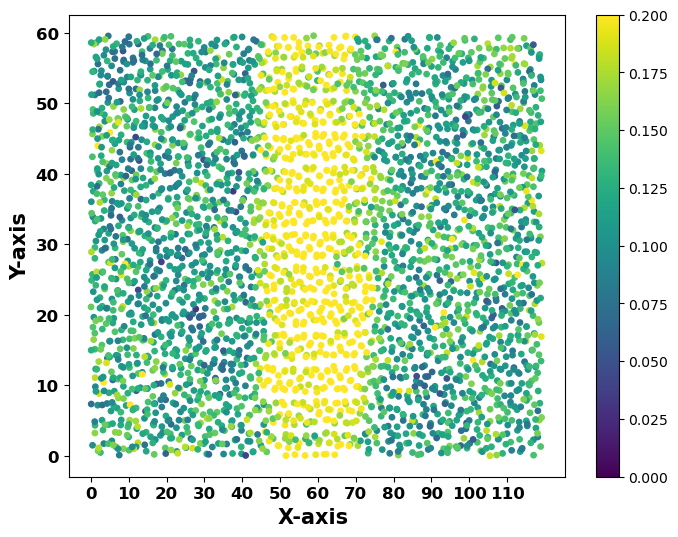

In [100]:
import numpy as np
import matplotlib.pyplot as plt
data_temp = results_xyz_q4_q6

# 从 data_list 中提取 x、y、q4 和 q6 数据
x_data = [item[0] for item in data_temp]
y_data = [item[1] for item in data_temp]
q4_data = [item[3] for item in data_temp]
q6_data = [item[4] for item in data_temp]

mean_q4 = sum(q4_data)/len(q4_data)
max_q4 = 0
for i in q4_data:
    if i>0.155:
        max_q4+=1
print('Mean q4:  ' + str(round(mean_q4,4))+'    Percentage of Q4 > 0.18: '+ str(round(max_q4/len(q4_data)*100,2))+'%')

# 创建二维分布图
plt.figure(figsize=(8, 6))

# 绘制 q4 在 x-y 平面上的二维分布图
title_name = 'LAS-1800K ' + str(50 + ana_frame) + ' ns'

plt.scatter(x_data, y_data, s=15, c=q4_data, cmap='viridis', marker='o',vmin=0.0, vmax=0.20)
plt.colorbar()
# plt.title(title_name , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗
plt.xlabel('X-axis ', fontsize=15, fontweight='bold')  # 设置 x 轴标签字体大小和加粗 
plt.ylabel('Y-axis', fontsize=15, fontweight='bold')  # 设置 y 轴标签字体大小和加粗 

# 设置 x 轴刻度值的字体大小、颜色和加粗
plt.xticks(range(0, int(max(x_data)) + 1, 10), fontsize=12, fontweight='bold')
# 设置 y 轴刻度值的字体大小、颜色和加粗
plt.yticks(fontsize=12, fontweight='bold')

# 显示图形
plt.show()


In [101]:
450/600 * 30

22.5

# ok

In [29]:
sss

NameError: name 'sss' is not defined

In [ ]:
mean_q4 = sum(q4_data)/len(q4_data)
print('Mean q4:' + str(round(mean_q4,4)))

# 计算所有Nb的和O的和Nb+O的所有均值

In [ ]:
draw_element = ['O']
r1_xyz_q4_q6 = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element:
        r1_xyz_q4_q6.append([i_atom[1],i_atom[2],i_atom[3],q4[i],q6[i]])
draw_element = ['O']
r2_xyz_q4_q6 = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element:
        r2_xyz_q4_q6.append([i_atom[1],i_atom[2],i_atom[3],q4[i],q6[i]])

In [ ]:
r1_q4 = sum([i[3] for i in r1_xyz_q4_q6])/len(r1_xyz_q4_q6)
r2_q4 = sum([i[3] for i in r2_xyz_q4_q6])/len(r2_xyz_q4_q6)
all_q4 = (sum([i[3] for i in r1_xyz_q4_q6])+sum([i[3] for i in r2_xyz_q4_q6]))/(len(r1_xyz_q4_q6)+len(r2_xyz_q4_q6))
out_content = '{:.5f} {:.5f} {:.5f}'.format(r1_q4, r2_q4, all_q4)
print(out_content)

In [ ]:
# 自定义 q4 和 q6 的范围
q4_range = [0.16, 1.0]

#########
import numpy as np
import matplotlib.pyplot as plt

# 示例数据，格式为 [x, y, z, q4, q6]
xyz_q4_q6 = results_xyz_q4_q6

# 提取 x、y、q4 和 q6 列
x_values = [item[0] for item in xyz_q4_q6]
y_values = [item[1] for item in xyz_q4_q6]
q4_values = [item[3] for item in xyz_q4_q6]
#q6_values = [item[4] for item in xyz_q4_q6]

# 根据条件筛选数据
filtered_indices = [i for i in range(len(q4_values)) if q4_range[0] <= q4_values[i] <= q4_range[1] ]
filtered_x = [x_values[i] for i in filtered_indices]
filtered_y = [y_values[i] for i in filtered_indices]

print(len(filtered_indices))
# 创建散点图
plt.figure(figsize=(8, 6))
plt.scatter(filtered_x, filtered_y, color='blue', alpha=0.8)
plt.title('Q4>0.16 ', fontsize=18, fontweight='bold')
plt.xlabel('X')
plt.xlim(0,95)
plt.ylim(0,95)
plt.ylabel('Y')


# 添加网格线，设置间隔为1
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5, color='gray', alpha=1)
plt.xticks(np.arange(0, 95, 20))
plt.yticks(np.arange(0, 95, 20))

# 添加X参考线
plt.axvline(x=20, color='black', linestyle='-')  
plt.axvline(x=40, color='black', linestyle='-')  
plt.axvline(x=60, color='black', linestyle='-') 
plt.axvline(x=80, color='black', linestyle='-')
# 添加Y参考线
plt.axhline(y=20, color='black', linestyle='-') 
plt.axhline(y=40, color='black', linestyle='-') 
plt.axhline(y=60, color='black', linestyle='-') 
plt.axhline(y=80, color='black', linestyle='-') 

plt.show()


In [ ]:
list_save = [filtered_x,filtered_y]
# 保存数据到文件
np.savetxt('filtered_data.txt', list_save)

In [ ]:
import matplotlib.pyplot as plt

# 假设 xlist 和 ylist 是你的数据
xlist = [1, 2, 3, 4, 5]
ylist = [2, 3, 5, 7, 11]

# 创建散点图
plt.scatter(xlist, ylist)

# 添加标题和标签
plt.title('Scatter Plot')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

# 显示图形
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据，格式为 [x, y, z, q4, q6]
xyz_q4_q6 = results_xyz_q4_q6

# 提取 x、q4 和 q6 列
x_values = np.array([item[0] for item in xyz_q4_q6])
q4_values = np.array([item[3] for item in xyz_q4_q6])
q6_values = np.array([item[4] for item in xyz_q4_q6])

bins = 1.0

x_min_bin =  min(x_values)
x_max_bin =  max(x_values)
# 自定义 bin 边界数组
custom_bins = np.arange(x_min_bin, x_max_bin+ bins, bins)

# 使用 np.histogram 计算直方图
hist, bin_edges = np.histogram(x_values, bins=custom_bins)

# 使用 np.digitize 将 x 映射到 bins 中的索引
x_bin_indices = np.digitize(x_values, bin_edges)

# 初始化存储均值的数组
q4_mean_values = np.zeros(len(custom_bins) - 1)
q6_mean_values = np.zeros(len(custom_bins) - 1)

# 计算每个 bin 中 q4 和 q6 的均值
for i in range(1, len(custom_bins)):
    q4_mean_values[i - 1] = np.mean(q4_values[x_bin_indices == i])
    q6_mean_values[i - 1] = np.mean(q6_values[x_bin_indices == i])

fig, ax1 = plt.subplots(figsize=(8, 6))

# 绘制均值随 x 的一维变化，改为折线图
ax1.set_xlabel('X-axis', fontsize=20, fontweight='bold')  # 设置 x 轴标签字体大小和加粗
ax1.set_ylabel('Mean Q4', color='tab:red', fontsize=20, fontweight='bold')  # 设置 y 轴标签字体大小、颜色和加粗
ax1.plot(bin_edges[:-1], q4_mean_values, color='tab:red', marker='o', linestyle='-', linewidth=2, markersize=4)
ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=20)  # 设置 y 轴刻度字体大小
ax1.tick_params(axis='x',  labelsize=20)  # 设置 x 轴刻度字体大小
print(str(ana_frame))
fig.tight_layout()
plt.show()

In [ ]:
ddddddd

In [ ]:
# 自定义 q4 和 q6 的范围
q4_range = [0.1, 1.0]
q6_range = [0.0, 1.0]

In [ ]:
x_origin =np.array([580,595,648,887,1171,1633,2262,2244,1599,799,580])

In [ ]:
x_origin

In [ ]:
x_origin =np.array([580,595,648,887,1171,1633,2262,2244,1599,799,580])

for i in x_origin:
    print((i-580)/(2262-580))